# Load the necessary packages

In [2]:
# Import libraries:
import numpy as np
import cv2
import pandas as pd
from skimage.io import imread
import skimage.io as ski
import os
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
# from patchify import patchify
import tifffile as tiff
from pathlib import Path
import matplotlib as mpl

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from PIL import Image


from Training_lib import Load_training_data, Split_data, Load_and_prepare_data, Main_model
from Prediction_lib import Large_pred
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize, to_categorical
import timeit
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import timeit
from Patches_lib import generate_patches
import math

# Use GPU

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

Gb_of_RAM = 10

tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*Gb_of_RAM)])


logical_gpus = tf.config.list_logical_devices('GPU')
print("Using", Gb_of_RAM, "Gb of RAM from ", len(gpus) ,"Physical GPU")

Num GPUs Available:  1
Using 10 Gb of RAM from  1 Physical GPU


# Plot Oxidation Surface fraction vs Oxydation Time


In [5]:
# ------------------------------------------------------------------------
#  Set Up Custom Style
# ------------------------------------------------------------------------
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['grid.alpha'] = 0.4
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['legend.fontsize'] = 8

# ------------------------------------------------------------------------
#  Segmentation over large image to compute surface fractions
# ------------------------------------------------------------------------
Patch_size = 256
Data_folder = 'Data'
n_classes = 4
Training_param = False

# Model name and emplacement:
Save_name      = 'UNet_' + str(Patch_size) + 'px_v1'
model_folder   = 'Saved_models/'
history_folder = 'Saved_history/'

if not os.path.exists(model_folder) and not os.path.exists(history_folder):
    os.mkdir(model_folder)
    os.mkdir(history_folder)
    print("Model and history directories created")
else:
    print("The model and history directories already exist.")

# Training/Loading:
model, history = Main_model(Save_name=Save_name, model_folder=model_folder, history_folder=history_folder, 
                            n_classes= n_classes, Patch_size = Patch_size,
                            Training_param = Training_param)

# Load data
All_Images_names = sorted(list(Path(Data_folder+'/SEM Image/').glob('*.tif')))
All_Labels_names = sorted(list(Path(Data_folder+'/Labels/').glob('*.tif')))

s = 256
Sf_pred_ox = np.zeros(len(All_Images_names))
Sf_gt_ox = np.zeros(len(All_Images_names))
for II in range(len(All_Images_names)):

    Image_name = All_Images_names[II]
    Label_name = All_Labels_names[II]
    
    Probability_map, Final_prediction = Large_pred(Image_name, Label_name, model, Patch_size, stride=s, Norm=True, tech=None)

    I = ski.imread(Image_name)
    L = ski.imread(Label_name)
    x_c = int(np.floor(I.shape[0]/Patch_size))
    y_c = int(np.floor(I.shape[1]/Patch_size))
    L_c = L[:x_c*Patch_size, :y_c*Patch_size]


    Sf_pred_ox[II] = np.sum(Final_prediction == 1)/(Final_prediction.shape[0]*Final_prediction.shape[1])
    Sf_gt_ox[II]   = np.sum(L_c == 85)/(Final_prediction.shape[0]*Final_prediction.shape[1])


The model and history directories already exist.
History loaded successfully
Processing image : Data/SEM Image/Image_0.tif
Iteration 1 out of 1


I0000 00:00:1746006035.102688 1384877 service.cc:146] XLA service 0x75793c00ccb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746006035.102755 1384877 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-04-30 11:40:35.122205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-30 11:40:35.236808: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1746006037.718157 1384877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Patch prediction done. Prediction time is: 0:08 min
Processing image : Data/SEM Image/Image_1.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:03 min
Processing image : Data/SEM Image/Image_2.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:03 min
Processing image : Data/SEM Image/Image_3.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:03 min
Processing image : Data/SEM Image/Image_4.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:03 min
Processing image : Data/SEM Image/Image_5.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:03 min
Processing image : Data/SEM Image/Image_6.tif
Iteration 1 out of 1
Patch prediction done. Prediction time is: 0:03 min


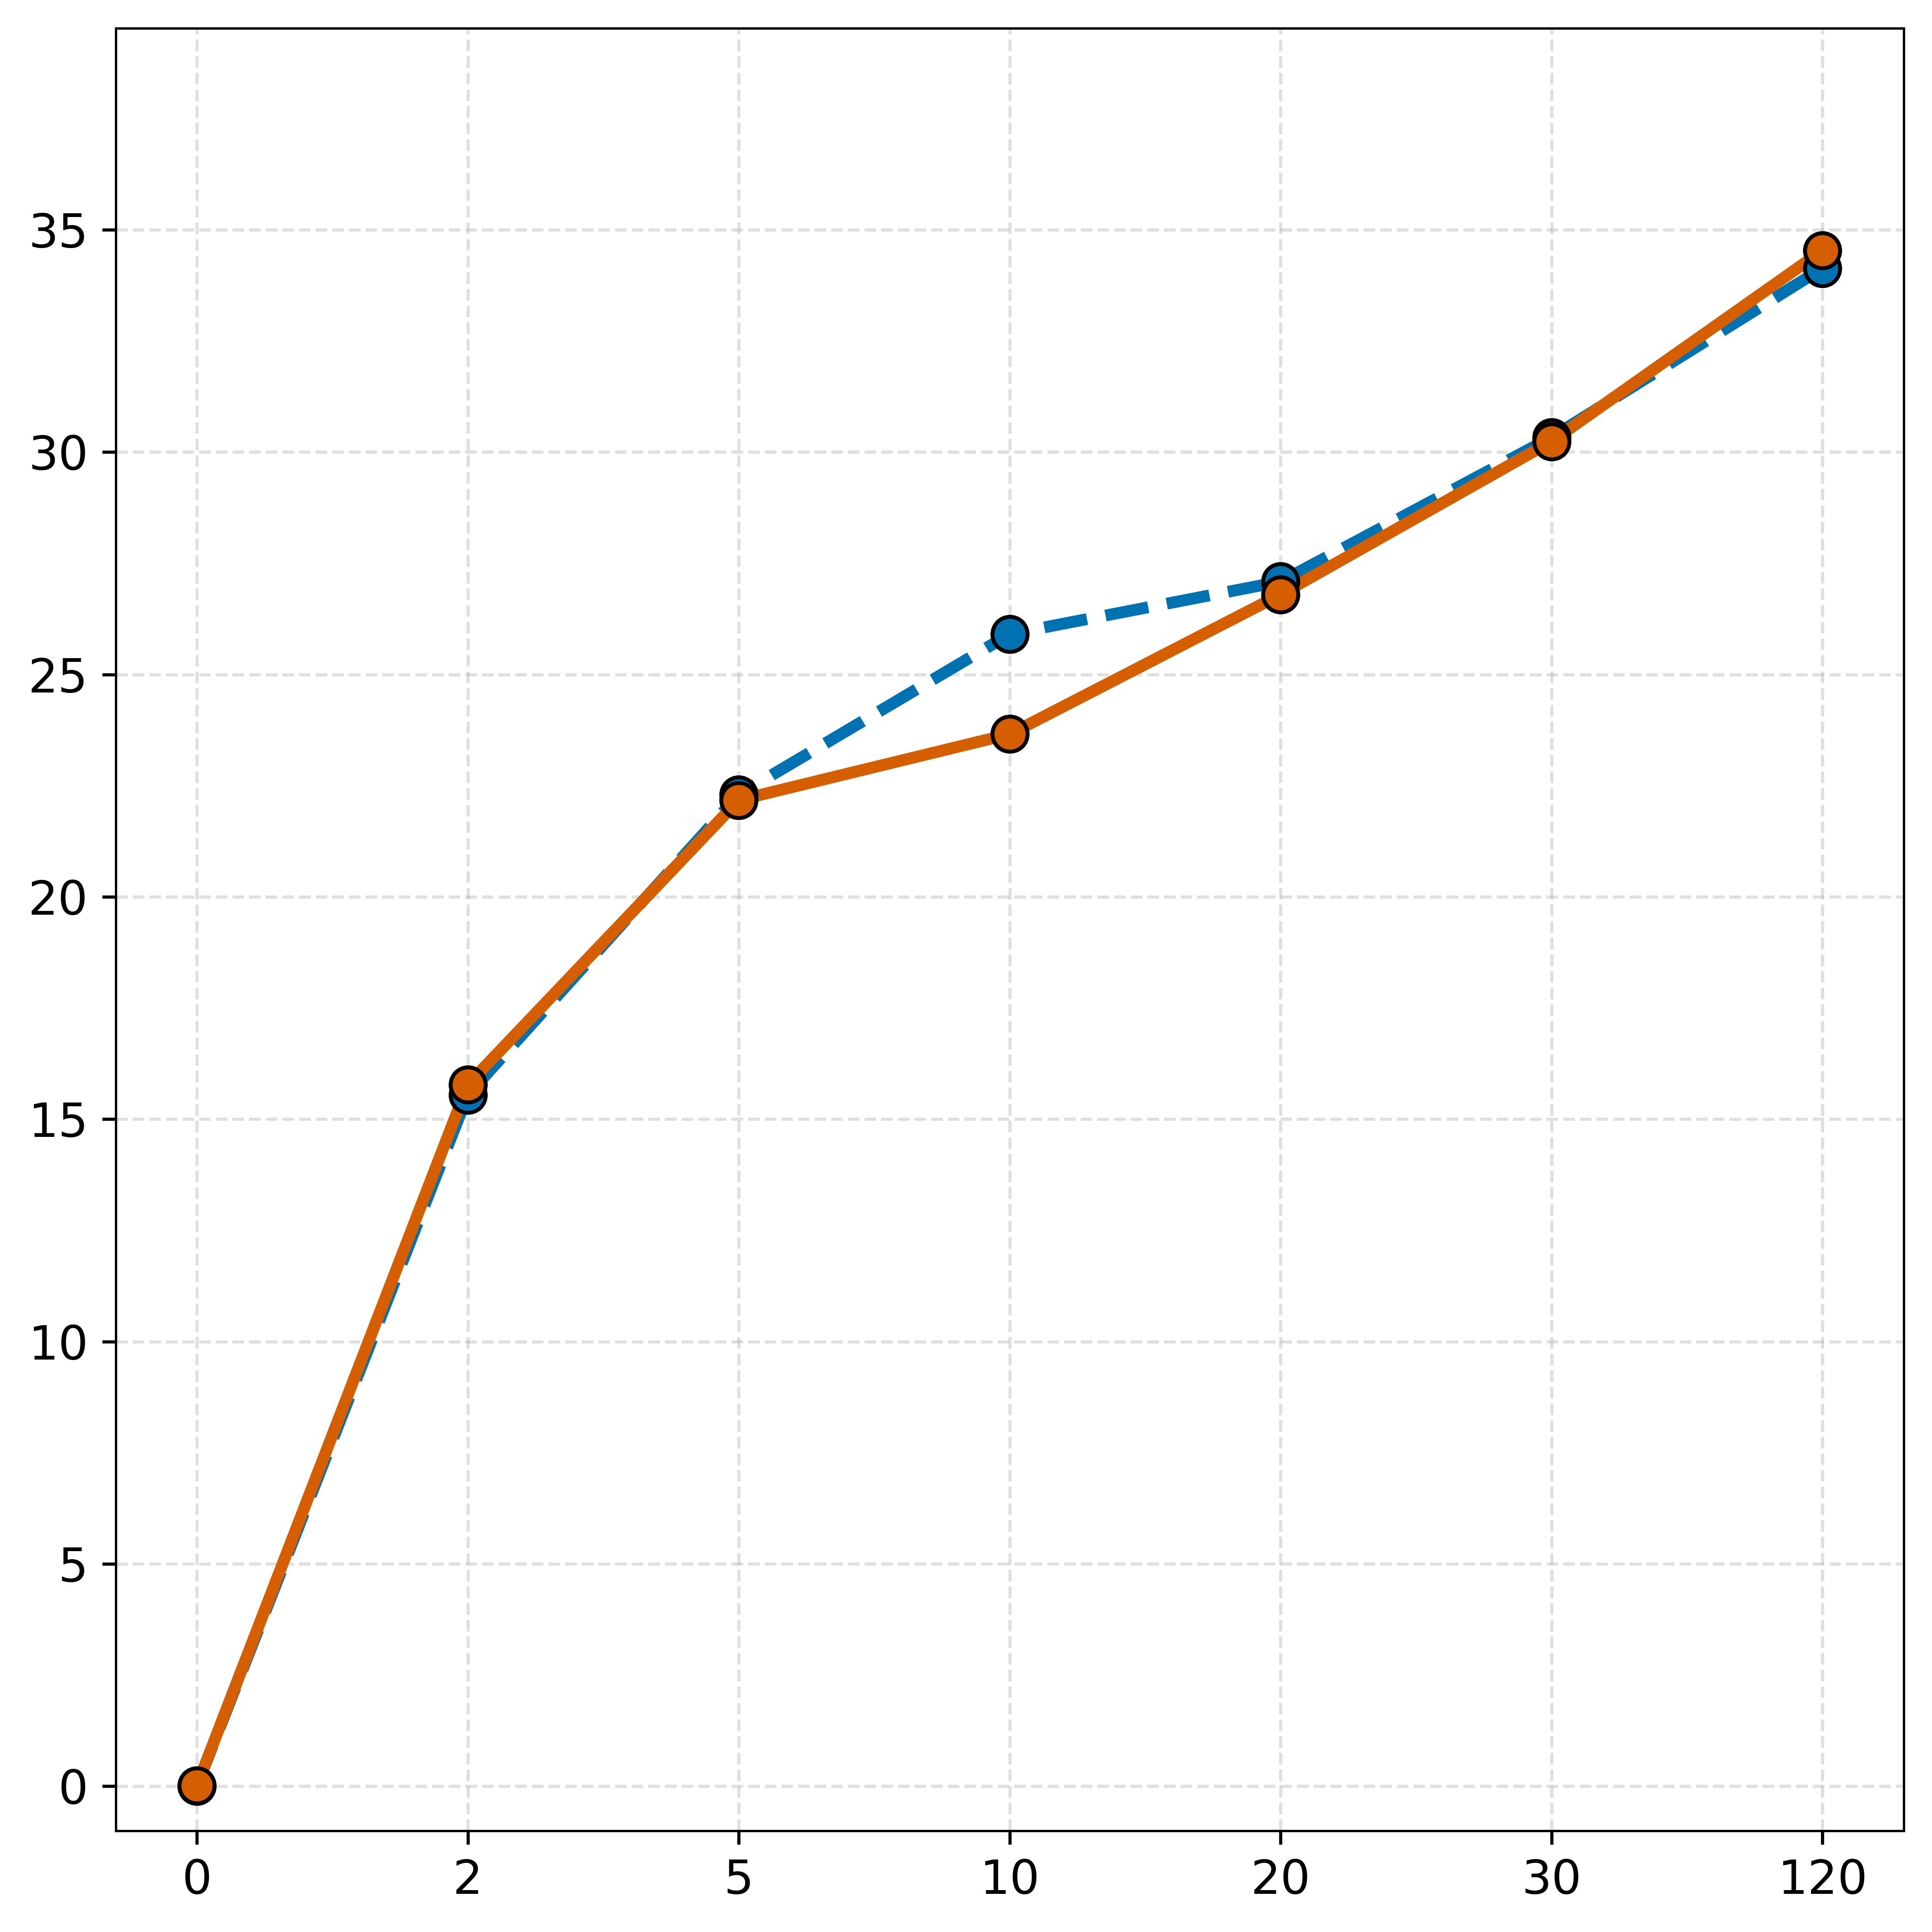

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

y  = Sf_gt_ox[[0,1,2,6,4,3,5]]*100  # Prediction
y2 = Sf_pred_ox[[0,1,2,6,4,3,5]]*100  # Target
x_positions = np.arange(len(y))
x_labels = ['0', '2', '5', '10', '20', '30', '120']  # minutes

# ------------------------------------------------------------------------
#  Plot
# ------------------------------------------------------------------------
plt.figure(figsize=(7, 7), dpi=600)
ax = plt.gca()
ax.grid(True, which='major', linestyle='--')

# Colors (colorblind-friendly palette)
prediction_color = "#0072B2"  # blue
target_color     = "#D55E00"  # reddish-orange   

# Main plot
ax.plot(x_positions, y, linestyle='--', color=prediction_color, linewidth=3, label="Prediction")
ax.scatter(x_positions, y, color=prediction_color, edgecolors='black', s=80, zorder=3)

ax.plot(x_positions, y2, linestyle='-', color=target_color, linewidth=3, label="Target")
ax.scatter(x_positions, y2, color=target_color, edgecolors='black', s=80, zorder=3)

# Custom ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)

# Set y-limits
y_combined = np.concatenate([y, y2])
ax.set_ylim(-1, np.max(y_combined) + 5)


# Zoom region (adjust according to your interest)
inset_ax.set_xlim(0, 3)  # indices for 0, 2, 5, 10 mins
inset_ax.set_ylim(min(np.min(y[:4]), np.min(y2[:4])) - 2, max(np.max(y[:4]), np.max(y2[:4])) + 2)
inset_ax.grid(True, linestyle=':', linewidth=0.5)

# Save and show
plt.tight_layout()
plt.savefig("Figure/Surface_fraction.tiff", format='tiff', dpi=600, bbox_inches='tight')
plt.show()


In [10]:
from tabulate import tabulate

y_true = y  # Reference curve (e.g., ground truth)
y_pred = y2  # Predicted curve (e.g., model prediction)

# Compute metrics
mse = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred))
std_error = np.std(np.abs(y_true - y_pred))
max_error = np.max(np.abs(y_true - y_pred))

# Organize data into table format
metrics_table = [
    ["Mean Squared Error (MSE)",      f"{mse:.3f}", "%²"],
    ["Root Mean Squared Error (RMSE)", f"{rmse:.3f}", "%"],
    ["Mean Absolute Error (MAE)",      f"{mae:.3f}", "%"],
    ["Std. Dev. of Absolute Error",    f"{std_error:.3f}", "%"],
    ["Maximum Absolute Error",         f"{max_error:.3f}", "%"],
]

# Print table
print("Comparison Metrics Between Prediction and Ground Truth:\n")
print(tabulate(metrics_table, headers=["Metric", "Value", "Unit"], tablefmt="fancy_grid"))

Comparison Metrics Between Prediction and Ground Truth:

╒════════════════════════════════╤═════════╤════════╕
│ Metric                         │   Value │ Unit   │
╞════════════════════════════════╪═════════╪════════╡
│ Mean Squared Error (MSE)       │   0.769 │ %²     │
├────────────────────────────────┼─────────┼────────┤
│ Root Mean Squared Error (RMSE) │   0.877 │ %      │
├────────────────────────────────┼─────────┼────────┤
│ Mean Absolute Error (MAE)      │   0.485 │ %      │
├────────────────────────────────┼─────────┼────────┤
│ Std. Dev. of Absolute Error    │   0.731 │ %      │
├────────────────────────────────┼─────────┼────────┤
│ Maximum Absolute Error         │   2.25  │ %      │
╘════════════════════════════════╧═════════╧════════╛


# Violin plot

The Violin plot shows the distribution of grayscale values for Prediction and Target across test images. The left half of each violin represents the Prediction, while the right half shows the Target distribution.

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns

# Load model:

Patch_size = 256
Data_folder = 'Data'
n_classes = 4
Training_param = False

# Model name and emplacement:
Save_name      = 'UNet_' + str(Patch_size) + 'px_v1'
model_folder   = 'Saved_models/'
history_folder = 'Saved_history/'

if not os.path.exists(model_folder) and not os.path.exists(history_folder):
    os.mkdir(model_folder)
    os.mkdir(history_folder)
    print("Model and history directories created")
else:
    print("The model and history directories already exist.")

# Training/Loading:
start = timeit.default_timer()

model, history = Main_model(Save_name=Save_name, model_folder=model_folder, history_folder=history_folder, 
                            n_classes= n_classes, Patch_size = Patch_size,
                            Training_param = Training_param)


The model and history directories already exist.
History loaded successfully


In [18]:
# Load testing data set:
Testing_im_path = Path(Data_folder) / f'Testing_Images_{Patch_size}'
Testing_lb_path = Path(Data_folder) / f'Testing_Labels_{Patch_size}'

_, _, _, _, _, _, X_test_viol, y_test, y_test_cat = Load_and_prepare_data(
    for_training=False,
    data_dir=(Testing_im_path,Testing_lb_path), patch_size=Patch_size, 
    val_perc=None, n_classes=n_classes, 
    normalize_images=False, 
    shuffle=False
)


_, _, _, _, _, _, X_test, y_test, y_test_cat = Load_and_prepare_data(
    for_training=False,
    data_dir=(Testing_im_path,Testing_lb_path), patch_size=Patch_size, 
    val_perc=None, n_classes=n_classes, 
    normalize_images=True, 
    shuffle=False
)
# Placeholder for the data
data = []

range_max = X_test.shape[0]
num_values = 4

# Generate the random vector
random_vector = np.random.choice(range_max, num_values, replace=False)

for j in random_vector:
    # Predict segmentation map for the current image
    y_pred_test = model.predict(X_test[j, :, :, 0].reshape((1, 256, 256, 1)), verbose=0)
    predii = np.argmax(y_pred_test, axis=-1)

    # Extract segmentation map, target map, and grayscale image
    segmentation_map = predii[0, :, :]
    target_map = y_test[j, :, :, 0]
    grayscale_image = X_test_viol[j, :, :, 0]

    # Ensure the images have the same dimensions
    # assert segmentation_map.shape == grayscale_image.shape, "Segmentation map and grayscale image must have the same dimensions."
    # assert target_map.shape == grayscale_image.shape, "Target map and grayscale image must have the same dimensions."

    # Process predicted segmentation map
    unique_classes_seg = np.unique(segmentation_map)
    for class_id in unique_classes_seg:
        class_mask = (segmentation_map == class_id)
        class_grayscale_vector = grayscale_image[class_mask].flatten()
        data.extend([(class_id, value, 'Prediction') for value in class_grayscale_vector])

    # Process target map
    unique_classes_target = np.unique(target_map)
    for class_id in unique_classes_target:
        class_mask_t = (target_map == class_id)
        class_grayscale_vector_target = grayscale_image[class_mask_t].flatten()
        data.extend([(class_id, value, 'Target') for value in class_grayscale_vector_target])
        

# Convert data to DataFrame for seaborn
columns = ['Class', 'Grayscale Value', 'Source']
df = pd.DataFrame(data, columns=columns)

# print(df)

# Define the mapping from numeric class IDs to class names
class_labels = {0: 'Porosity', 1: 'NiO', 2: 'Ni', 3: 'YSZ'}

# Replace the numeric class IDs in the DataFrame with their corresponding labels
df['Class'] = df['Class'].map(class_labels)

Loading images...


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 574.69it/s]


Images loaded and processed. Shape: (140, 256, 256)
Loading masks...


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 625.85it/s]


Masks loaded and processed. Shape: (140, 256, 256)
Number of Training samples    = 0
Number of Validation samples  = 0
Number of Test samples        = 140
Loading images...


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 635.65it/s]


Images loaded and processed. Shape: (140, 256, 256)
Loading masks...


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 628.40it/s]


Masks loaded and processed. Shape: (140, 256, 256)
Number of Training samples    = 0
Number of Validation samples  = 0
Number of Test samples        = 140


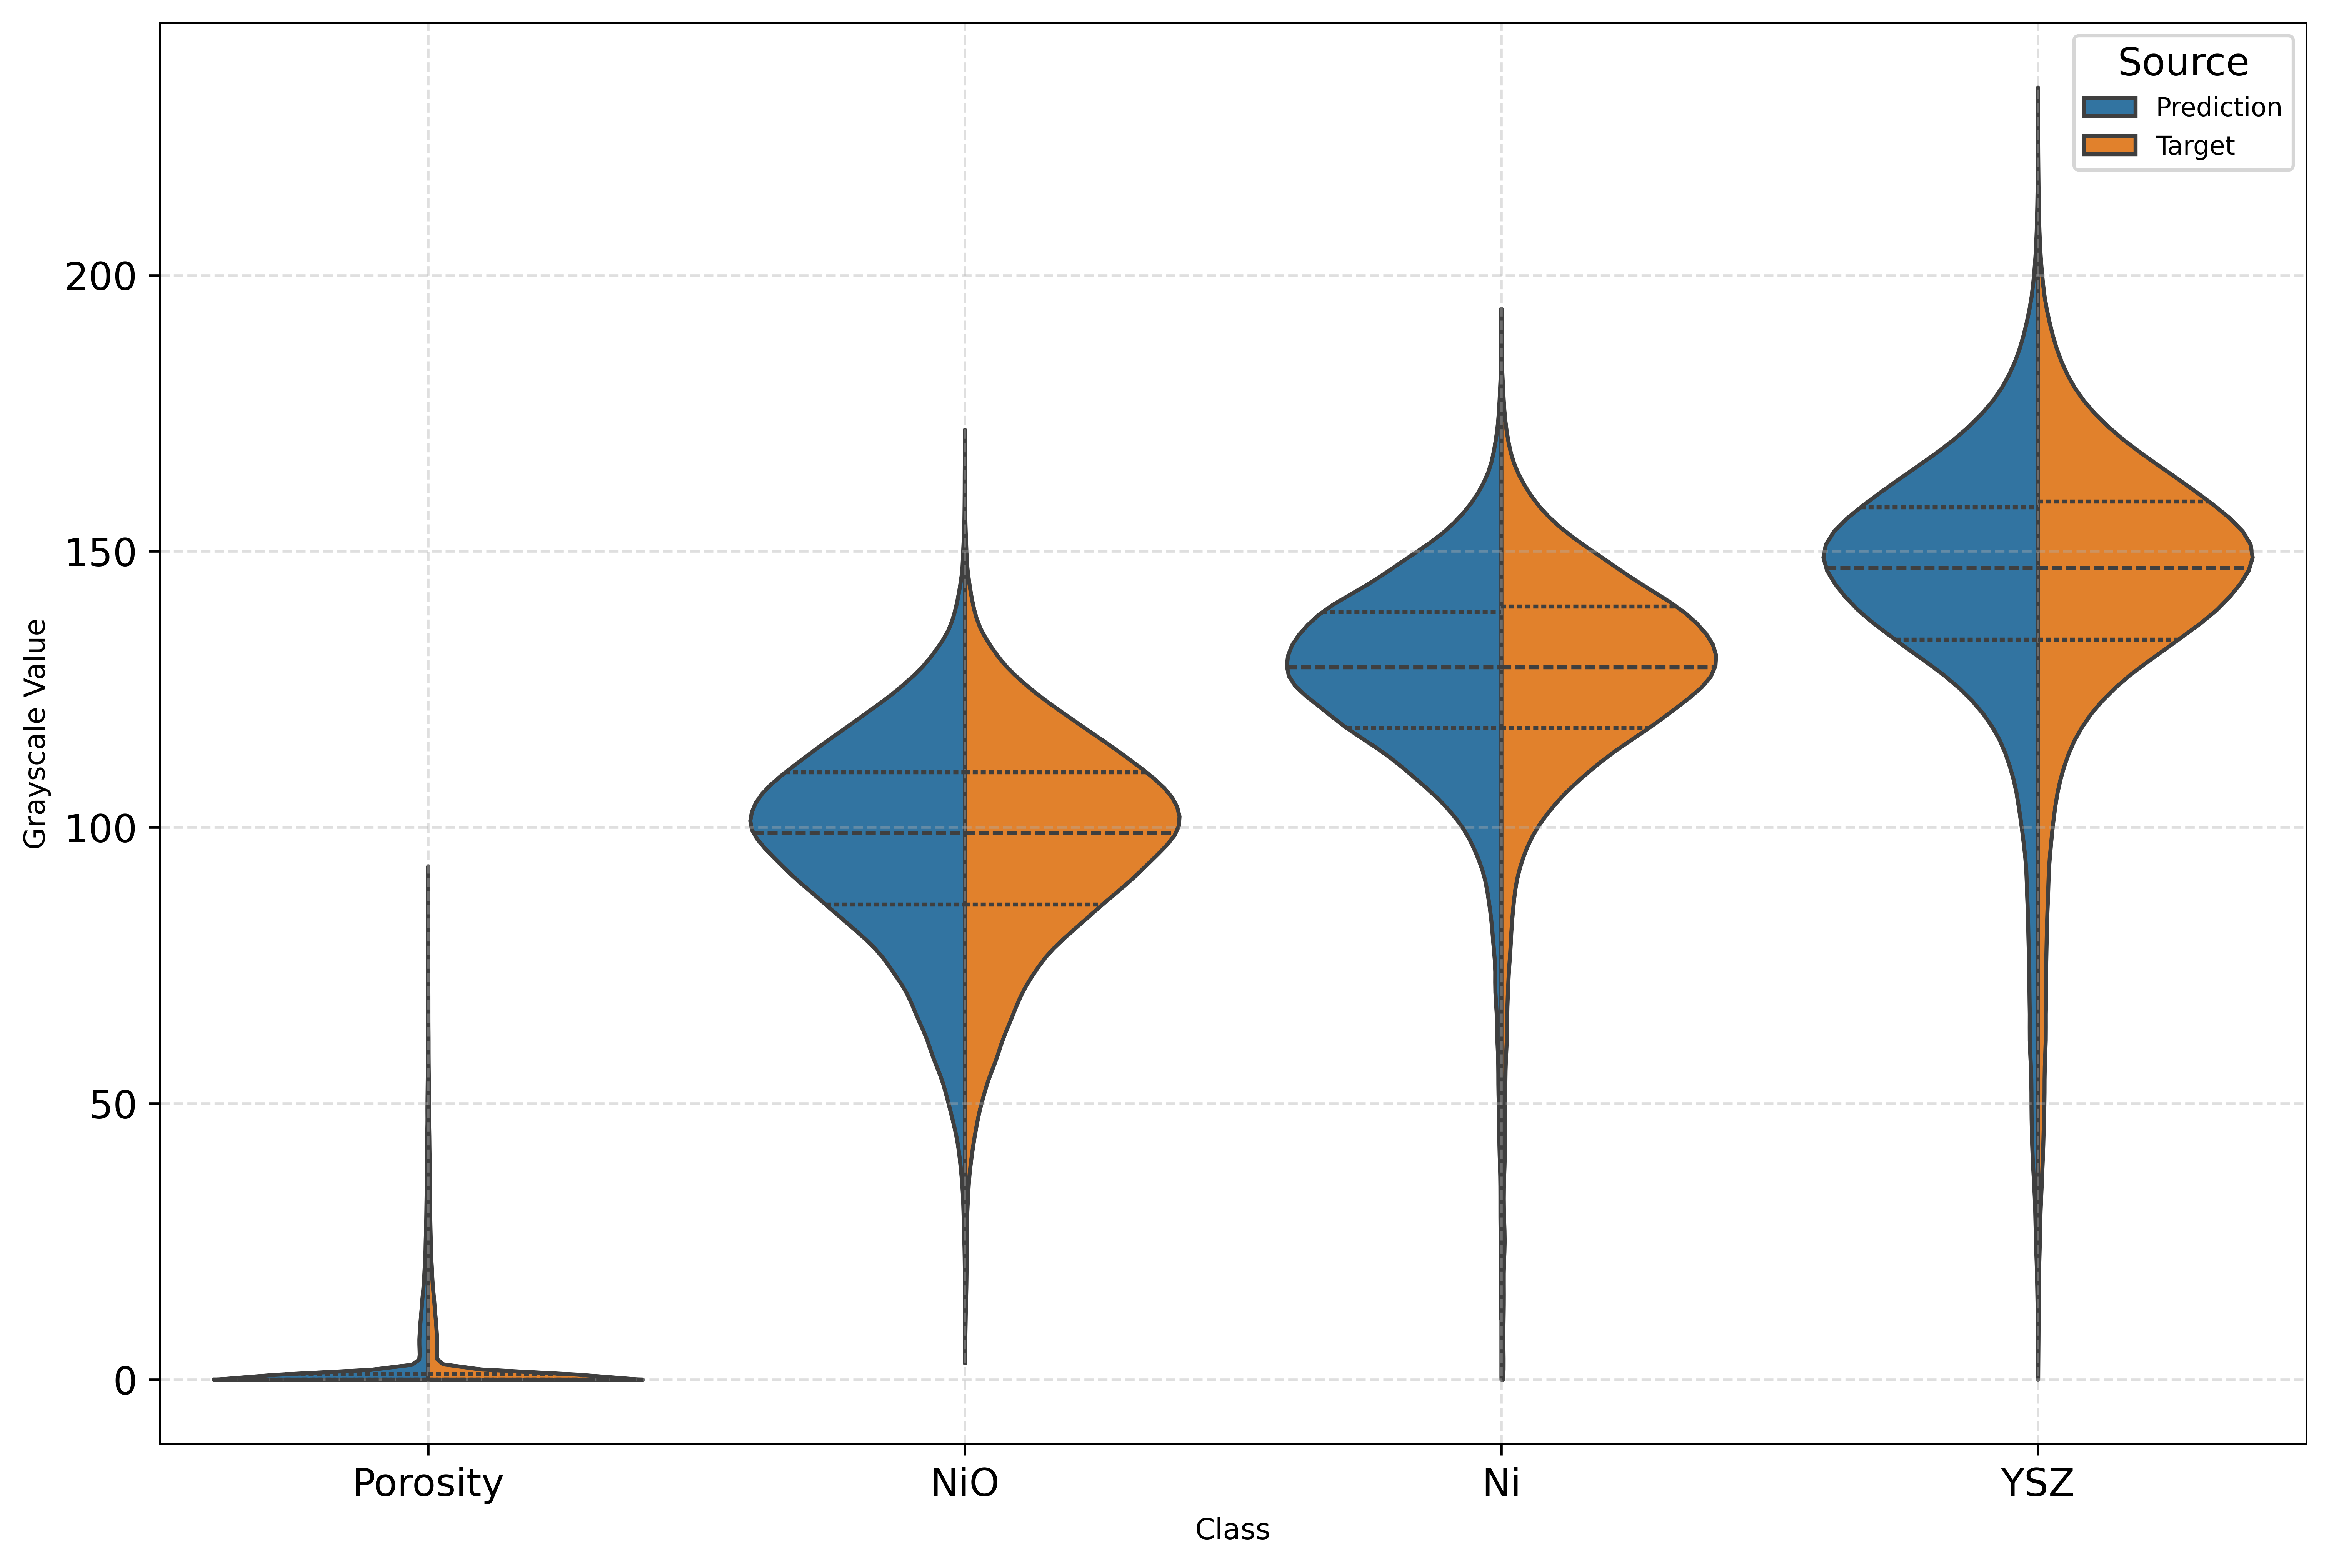

In [23]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x="Class", y="Grayscale Value", hue="Source", split=True, inner="quart", density_norm = "width", common_norm = True, cut=0)
# plt.xlabel('Classes')
# plt.ylabel('Grayscale Values')
# plt.legend(title="Source")
plt.grid()
plt.savefig('Figure/violin_plot.png', dpi=600, bbox_inches='tight')
plt.show()